# Lab 3 - Filter banks

Explore the design of filter banks, first designing the bandpass filters and building a filter bank structure that is able to obtain a perfect reconstruction of a sound.

## References:

### Low-pass filter
A low-pass filter is a filter that passes signal components with frequencies lower than a selected cutoff frequency and attenuates signal components with frequencies higher than the cutoff frequency.

### firwin
Algorithm in `scipy.signal`to perform an FIR filter design using the window method. This involves designing an ideal filter in the frequency domain and then applying a window function to smooth the frequency response and limit the number of taps (filter order).

### Bandpass filter
A band-pass filter is a filter that passes frequencies within a certain range and rejects (attenuates) frequencies outside that range. It's the opposite of a band-stop filter.

### Impulse response of a filter
A filter's impulse response function is simply the output of the filter when the input is an impulse of amplitude 1 at time zero.

### Frequency response of a filter
The frequency response of a filter is computed by taking the Fourier Transform of the impulse response and tells us how the filter affects the magnitudes and phases of the frequencies of a signal.

### Filter bank structure
An array of bandpass filters that separates the input signal into multiple components, each one carrying a sub-band of the original signal.

### Perfect reconstruction
Coding/decoding with which we recover the origianl sound identically.

### Critical sampling
In audio coding, critical sampling means that the encoding representation is of the same size than the original signal.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.fft import fft
from scipy import signal as signal

In [3]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

def prototype_filter(N, L):
  """ Generate a prototype FIR low-pass filter using a window method.
    Args:
      N (int): length of filter
      L (int): number of subbands
    Returns:
      Coefficients of the resulting FIR filter
  """
  return signal.firwin(N, 1.0 / (2 * L), window='hamming')

def modulate_filter(h, M, k):
    # Modulate the prototype filter
    n = np.arange(len(h))
    modulation = 2 * np.cos(np.pi * (2 * k + 1) * (n - (len(h) - 1) / 2) / (2 * M))
    return h * modulation

def analysis_filter_bank(x, M, N):
    # Analysis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    subband_length = len(x) // M
    subbands = np.zeros((M, subband_length))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        filtered_signal = signal.lfilter(hk, 1.0, x)
        # Ensure the subband length matches the expected size
        downsampled_signal = filtered_signal[::M]
        if len(downsampled_signal) > subband_length:
            subbands[k] = downsampled_signal[:subband_length]
        else:
            subbands[k, :len(downsampled_signal)] = downsampled_signal

    return subbands

def synthesis_filter_bank(subbands, M, N):
    # Synthesis Filter Bank using Polyphase Decomposition
    h = prototype_filter(N, M)
    y_reconstructed = np.zeros(M * len(subbands[0]))

    for k in range(M):
        hk = modulate_filter(h, M, k)
        upsampled_signal = np.zeros(len(y_reconstructed))
        upsampled_signal[::M] = subbands[k]  # Upsample by M
        y_reconstructed += signal.lfilter(hk, 1.0, upsampled_signal)

    return y_reconstructed

## Part 1 - Low-pass filtering

Design a low-pass filter using the window method, `firwin` algorithm, and filter a sound with it. Answer the questions given and modify the code to support your answers.

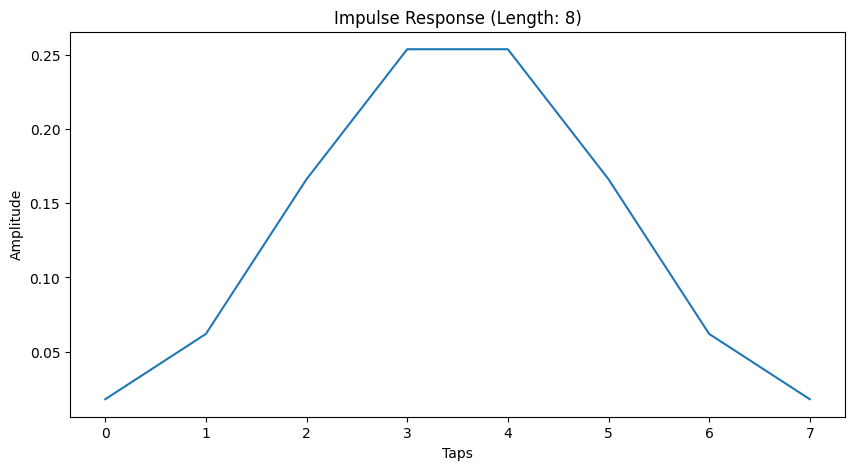

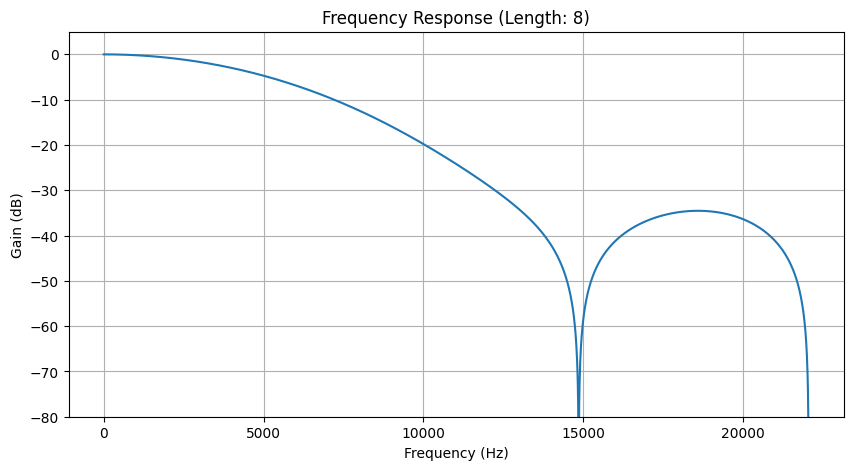

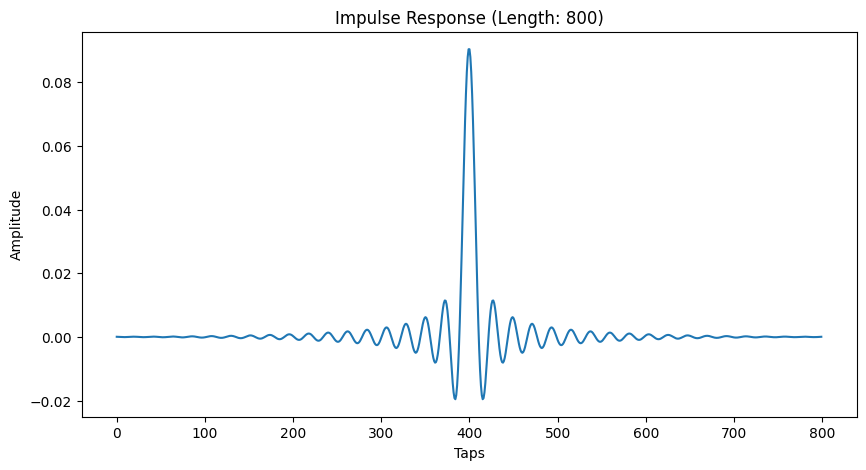

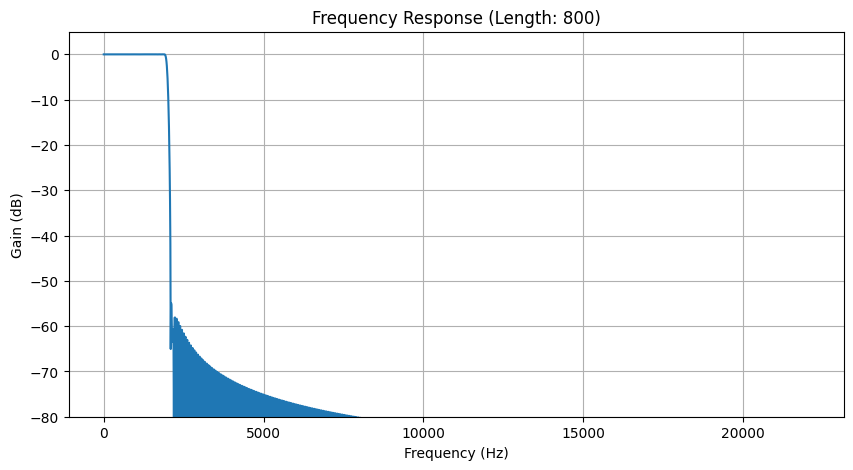

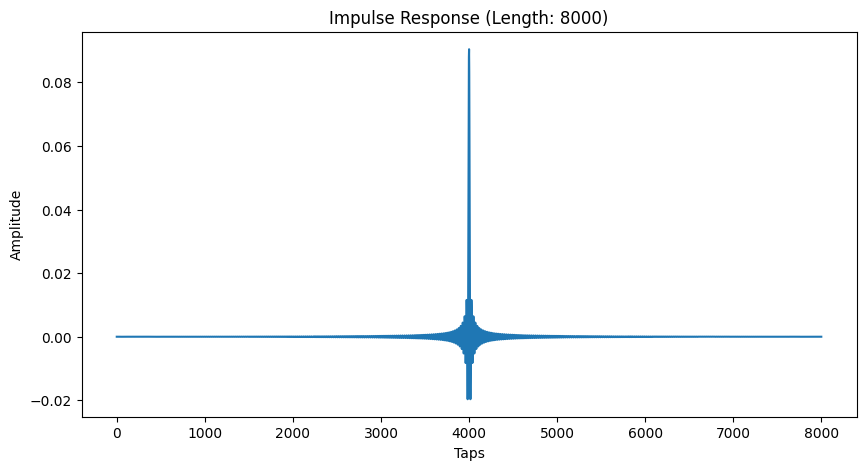

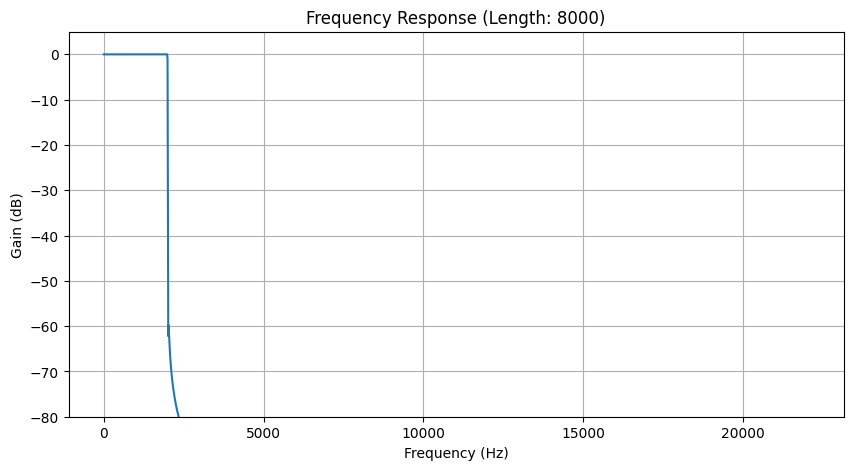

In [4]:
# design a low pass filter
fs = 44100.0
filter_lengths = [8, 800, 8000] # 8, 800, 8000
cutoff = 2000

for filter_length in filter_lengths:
    h = signal.firwin(filter_length, cutoff, window='hamming', fs=fs)

    # plot impulse response of filter
    plt.figure(figsize=(10, 5))
    plt.plot(h)
    plt.title(f'Impulse Response (Length: {filter_length})')
    plt.xlabel('Taps')
    plt.ylabel('Amplitude')
    plt.show()

    # plot frequency response of filter
    w, H = signal.freqz(h, [1], worN=2000, fs=fs)
    plot_freq_response(w, H, f'Frequency Response (Length: {filter_length})')
    plt.show()

In [5]:
# filter a sound with the lowpass filter
sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/white-noise.wav')

# filter for each lenght
for filter_length in filter_lengths:
    h = signal.firwin(filter_length, cutoff, window='hamming', fs=fs)

    # apply filter by convolving the sound with the impulse response of filter
    filtered_sound = signal.lfilter(h, 1, sound_array)

    # display original sound
    print(f'Original (Length: {filter_length})')
    ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
    display_spectrogram(sound_array, 512, 1024, sampling_rate)

    # display filtered sound
    print(f'Filtered (Length: {filter_length})')
    ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
    display_spectrogram(filtered_sound, 512, 1024, sampling_rate)

Output hidden; open in https://colab.research.google.com to view.

**Questions:**

1. **Design a lowpass filter with cutoff frequency of 2000Hz, using the `firwin` algorithm with different values for filter-length. Try values of 8, 800, 8000. Show the frequency responses and explain the differences.**

  Amb una longitud del filtre 8, veiem que la resposta en freqüència no s'apropa gens a la ideal, sinó que presenta oscilacions i no es veu la cutoff frequency adequada, aleshores podem dir que aquesta longitud es massa curta amb capacitat limitada per gestionar la freqüència de tall. En canvi, les gràfiques dels filtres de longitud 800 i 8000 mostren una resposta molt més definida, amb una caiguda clara a 2000 Hz que forma un perfil quasi rectangular. Aquestes millores es deuen a que els filtres més llargs tenen més coeficients, cosa que els permet una millor aproximació de la resposta ideal, ja que fa una separació molt més efectiva entre les freqüències que passen i les que s'atenuen.

2. **Filter the sound `white-noise.wav` with the filters designed in question 1. Listen and explain the results, supporting it by showing the spectrograms of the filtered sounds.**

  Si mirem els espectogrames, el filtre de longitud 8 mostra poca atenuació i artefactes a les freqüències més altes. El filtre de longitud 800 presenta una millor definició, amb una clara atenuació per sobre de 2000 Hz. Finalment, el filtre de longitud 8000 veiem que té molta més definició i atenua perfectament les frequències per sobre de 2000 Hz.  A mesura que la longitud del filtre augmenta, el so es torna menys 'brillant' o més 'apagat', ja que es redueix la quantitat d'alta freqüència, creant una sensació de suavitat en el resultat final.
---

## Part 2 - Bank of bandpass filters

Design a bank of band-pass filters and apply it to a sound. Answer the questions given and modify the code to support your answers.

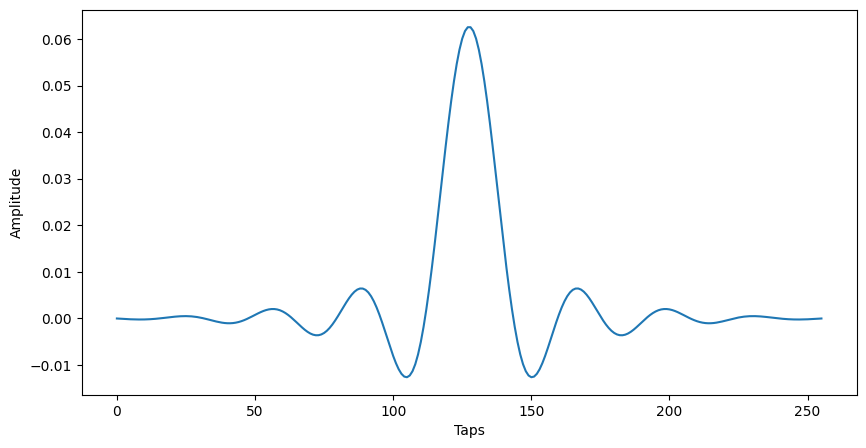

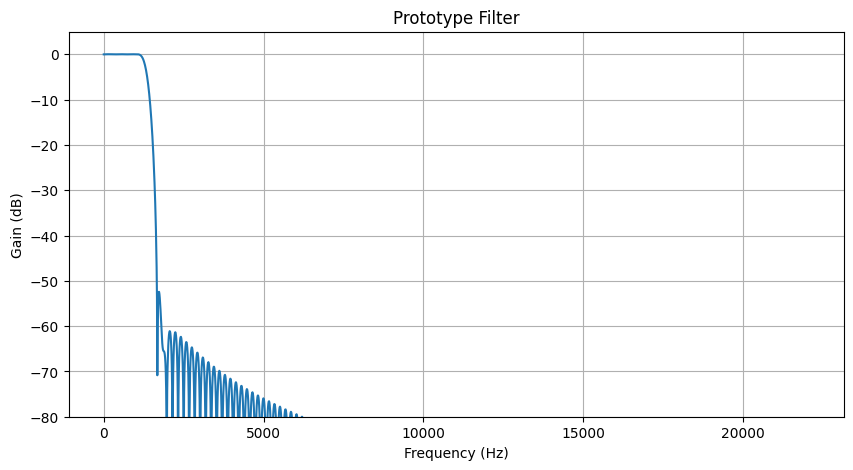

<Figure size 1000x500 with 0 Axes>

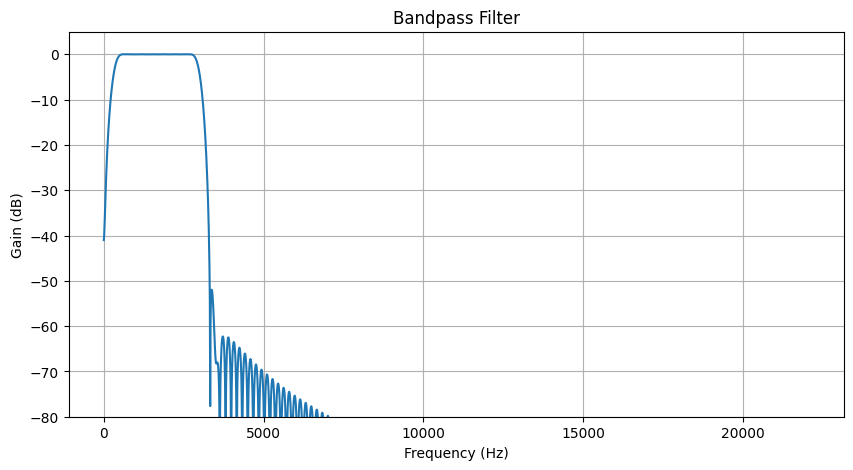

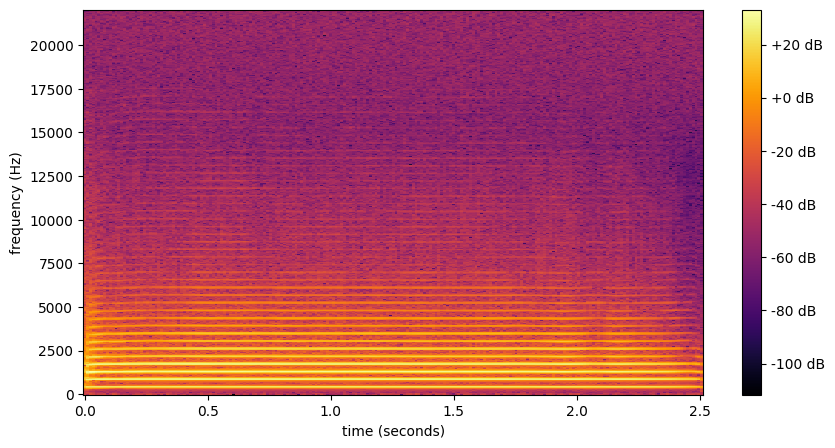

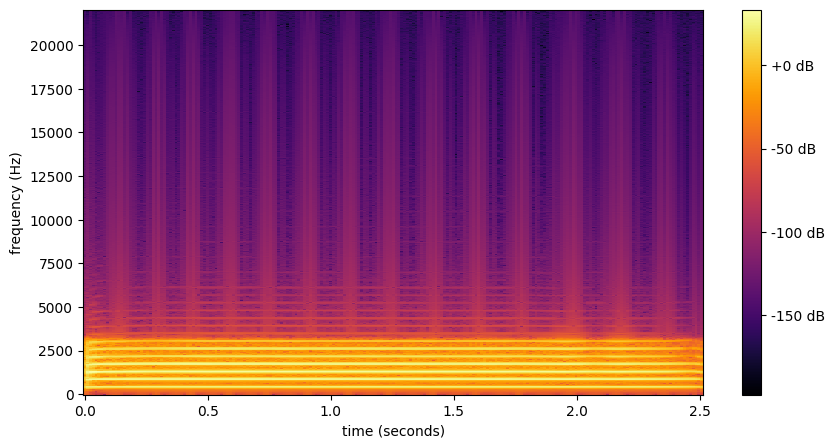

In [53]:
# Parameters for the filter bank
N = 256  # Length of the prototype filter
L = 8  # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# Plot the prototype filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')

w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Prototype Filter")
plt.show()

# Create a bandpass filter
k = 0.1  # index of a band pass filter
hk = modulate_filter(h, L, k)

plt.figure(figsize=(10, 5))
w, H = signal.freqz(hk, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Bandpass Filter")
plt.show()

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/487465-trumpet.wav')
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)

# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(hk, 1, sound_array)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)


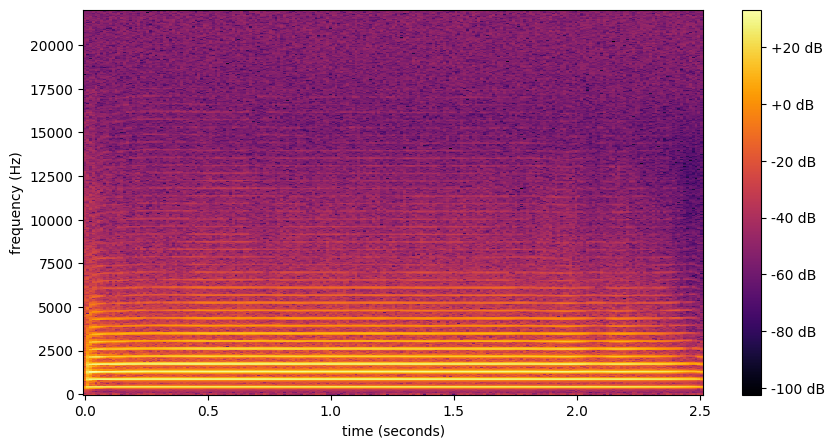

In [47]:
y = np.zeros(len(sound_array))

# apply the whole filter bank to a sound
for k in range(L):
  # Modulate prototype filter
  hk = modulate_filter(h, L, k)
  # Filter the signal
  filtered_sound = signal.lfilter(hk, 1, sound_array)
  y += filtered_sound

# display filtered sound
ipd.display(ipd.Audio(data=y, rate=sampling_rate))
display_spectrogram(y, 512, 1024, sampling_rate)

**Questions**
1. **Implement a low-pass filter and convert it to a band-pass filter. Explain how it works. Implement one example of a bandpass filter (define your own variables) and explain the result obtained when applying it to a particular sound (use one of the sounds in the sound directory).**

  Al aplicar un filtre passa-banda (BPF) amb paràmetres k=0.1, N=256 i L=8 al so d'una trompeta, es realça les freqüències fonamentals de l'instrument, millorant la seva claredat. Aquest filtre redueix els sorolls no desitjats i fa que el so de la trompeta es senti millor i més agradable.

2. **Implement a complete filter bank, apply it to the sound chosen in question 1 and try to get the best reconstruction by changing the size of the filters, N, and the number of filters, L. Explain the result.**

  Al aplicar un filtre complet a un senyal d'àudio, es milloren les freqüències importants de la trompeta, fent que soni més clara i present. Cada subbanda filtra el so original, i la suma dels resultats crea un so més net i ric. L'espectrograma mostra que les freqüències fonamentals de la trompeta són més fortes, mentre que els sorolls no desitjats es redueixen, resultant en un so més suau.





---

## Part 3 - Critical sampling
Experiment with critical sampling (the bandpass signals ocupy the same memory than the original signal), choosing the value L as the number of subbands, then downsampling each filtered band by L and finally upsampling them by L at the reconstruction stage.

Original signal size: 112076
Encoded signal size after downsampling: 3503


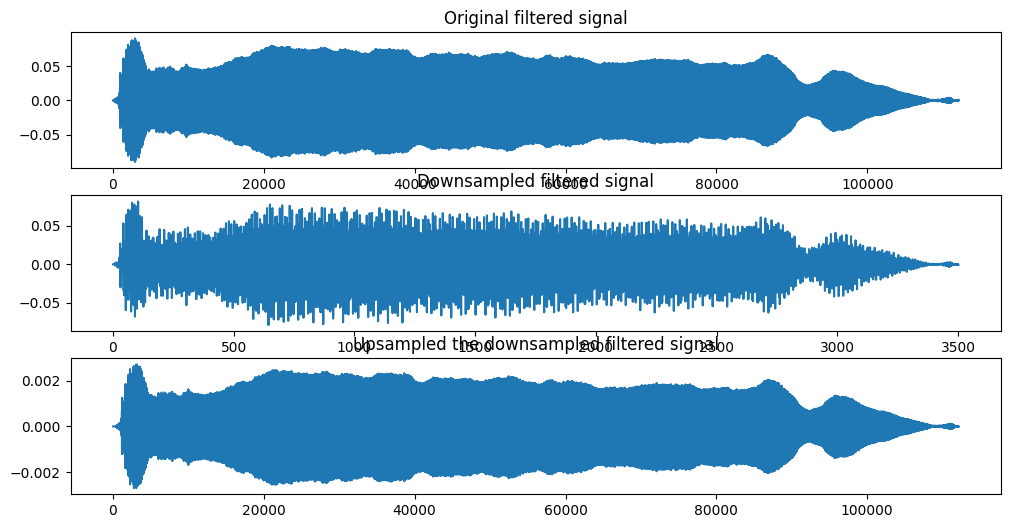

In [64]:
# downsample and upsample a filtered signal

# Parameters for the filter bank
N = 516  # Length of the prototype filter
L = 32   # Number of subbands
fs = 44100  # Sampling rate

# Generate the prototype filter
h = prototype_filter(N, L)

# generate bandpass filter
k = 3
hk = modulate_filter(h, L, k)

# filter a sound with the bandpass filter
sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/487465-trumpet.wav')

# Filter the signal
y = signal.lfilter(hk, 1.0, sound_array)
# down-sample the filtered signal
yd = y[::L]

# Upsample
yu = np.zeros(len(yd) * L)
yu[::L] = yd
# Filter with same filter than in encoding
yu = signal.lfilter(hk, 1.0, yu)

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title("Original filtered signal")
ipd.display(ipd.Audio(data=y, rate=sampling_rate))

plt.subplot(3, 1, 2)
plt.plot(yd)
plt.title("Downsampled filtered signal")
ipd.display(ipd.Audio(data=yd, rate=sampling_rate/L))

plt.subplot(3, 1, 3)
plt.plot(yu)
plt.title("Upsampled the downsampled filtered signal")
ipd.display(ipd.Audio(data=yu, rate=sampling_rate))
plt.show()

Original signal size: 112076
Total size of subbands: 112070
Reconstructed signal size: 112070


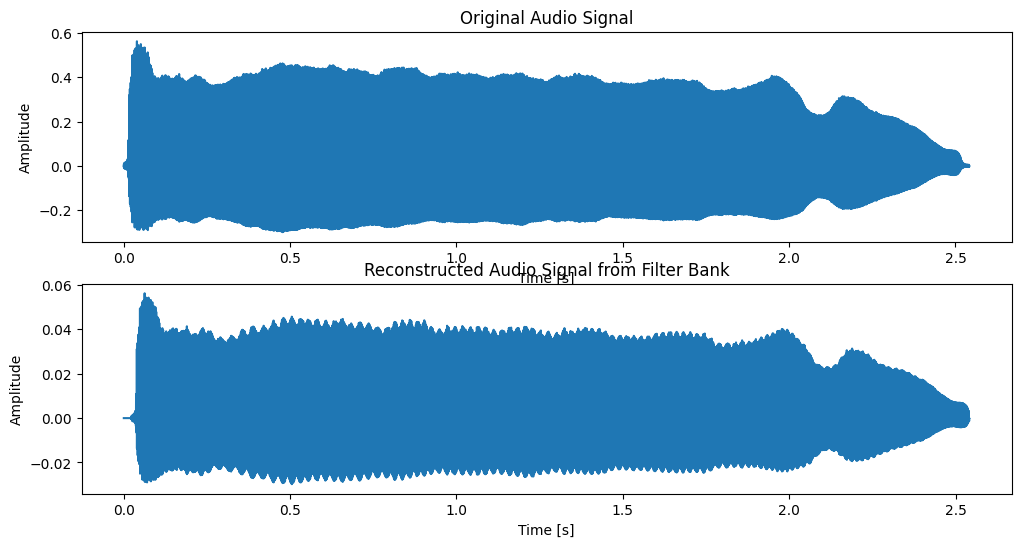

In [67]:
# encode and decode a signal with an bank of filters

# Parameters for the filter bank
N = 1024  # Length of the prototype filter
L = 10   # Number of subbands
fs = 44100  # Sampling rate

sound_array, sampling_rate = read_sound('/content/drive/MyDrive/UNI/UPF/5è CURS/1r TRIM/SISTEMES DE CODIFICACIÓ ÀUDIO I VÍDEO/audio-coding-materials-main/sounds/487465-trumpet.wav')
t = np.linspace(0, len(sound_array)/sampling_rate, len(sound_array), endpoint=False)

# Analysis (encoding): split the signal into subbands
subbands = analysis_filter_bank(sound_array, L, N)

# Synthesis (decoding): reconstruct the signal from subbands
reconstructed_signal = synthesis_filter_bank(subbands, L, N)

# EX 2
original_size = len(sound_array)
subbands_size = sum(len(subband) for subband in subbands)
reconstructed_size = len(reconstructed_signal)

print(f"Original signal size: {original_size}")
print(f"Total size of subbands: {subbands_size}")
print(f"Reconstructed signal size: {reconstructed_size}")

# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sound_array)
plt.title("Original Audio Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

plt.subplot(2, 1, 2)
plt.plot(t[:len(reconstructed_signal)],reconstructed_signal)
plt.title("Reconstructed Audio Signal from Filter Bank")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
ipd.display(ipd.Audio(data=reconstructed_signal, rate=sampling_rate))

plt.show()

**Questions:**

1. **Create a filter bank for L number of subbands. Apply it to a sound from the sounds directory while downsampling by L the subbands (encoded signal), then upsampling the subbands and addindg them together (decoded signal). Try to get the best reconstruction by trying different filter lengths (ex: 64, 128, 256). Explain the result.**

  Al utilitzar una longitud de filtre més alta (512 o més), es millora la reconstrucció del senyal perquè un filtre més llarg proporciona una millor atenuació de les freqüències no desitjades i una resposta en freqüència més precisa. Això significa que les subbandes es poden capturar i reconstruir amb més detall, resultant en un so molt més semblant al senyal original.

2. **Prove that the encoding process performs critical sampling, so the size of all the subbands (the encoded matrix) is equal to the size of the input signal. Add the needed code.**

  Veiem que el procés de codificació fa un mostreig crític, ja que la mida del senyal original és 112076, mentre que la mida total de les subbandes i el senyal reconstruït és 112070. Aquesta petita diferència pot ser la manera com es filtra i processa el so, i algunes mostres poden perdre's, però podem veure que el mostreig crític és gairebé ideal.
